# MRMS Reflectivity Animation: July 4, 2025

## Overview

#### This notebook walks through how to access, visualize, and animate low-level composite reflectivity data from the Multi-Radar/Multi-Sensor (MRMS) system.

The case study focuses on the Central Texas flood event in July 2025, using reflectivity data hosted on AWS. The main steps include:
- Selecting and downloading MRMS data for specific timestamps
- Creating a static reflectivity map
- Building an animation to show reflectivity changes over time

This notebook is intended for students, forecasters, or researchers looking to explore radar visualization techniques or build familiarity with remote sensing workflows using Python.

### What is MRMS?

The Multi-Radar/Multi-Sensor (MRMS) system is a set of real-time analysis products developed by NOAA’s National Severe Storms Laboratory (NSSL). It brings together data from:
- Dozens of NEXRAD radars
- Surface observations
- Satellites
- Lightning detection networks

to create high-resolution snapshots of precipitation, severe weather, and related hazards.

MRMS updates every 2.5 minutes and is commonly used in operational forecasting, hydrology, aviation, and research.

---

### Goal of This Notebook

The goal of this notebook is to walk through a simple, practical workflow for visualizing radar reflectivity data using Python. Specifically, we’ll:

- Access MRMS Layer Composite Reflectivity Low data from AWS Open Data
- Plot a single reflectivity frame as a static map
- Animate a 6-frame sequence from July 4, 2025, during the Central Texas flood event
- Demonstrate how to work with gridded radar data using open-source tools like MetPy, Cartopy, and xarray

## Imports
below are the python packages that are used for this code

In [1]:
# Core packages
import numpy as np
import numpy.ma as ma
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables  # For NWS reflectivity colormap

# File handling (if you're downloading MRMS .grib2.gz files manually)
import urllib.request
import gzip
import tempfile

# Animation
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML  # To display the animation

## Define Timestamps and Colormap

To build the animation, we’ll use 6 hourly frames of MRMS data from the morning of July 4, 2025. Each timestamp matches a GRIB2 file available from the AWS MRMS archive.

We also define the standard NWS reflectivity colormap using MetPy, which gives us consistent color breaks every 5 dBZ which is a common setup for radar reflectivity plots.

### Access and Load MRMS Data

MRMS data is stored as .grib2.gz files on the AWS S3 public data bucket. Each file represents a single timestamp and product type.

In this step:
- We use urllib.request.urlopen() to **download the compressed file** directly from AWS
- We **decompress** it using Python’s built-in gzip module
- Then we load the GRIB2 file into an xarray.DataArray using the cfgrib engine

This approach lets us work with the data directly in Python without having to manually download or unzip anything ahead of time.

In [2]:
# Define the URL to the compressed MRMS GRIB2 file for a specific timestamp
url = "https://noaa-mrms-pds.s3.amazonaws.com/CONUS/LayerCompositeReflectivity_Low_00.50/20250704/MRMS_LayerCompositeReflectivity_Low_00.50_20250704-001040.grib2.gz"

# Download the file as bytes
response = urllib.request.urlopen(url)
compressed_file = response.read()

# Decompress and load into xarray using a temporary file
with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
    # Decompress the .gz content and write to temp file
    f.write(gzip.decompress(compressed_file))

    # Load GRIB2 data as an xarray DataArray
    data_in = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


## Set Up Reflectivity Colormap and Extract Data

This section gets the MRMS reflectivity data ready for plotting and builds a map to visualize it.

- **Colormap and Normalization:**  
  We use MetPy’s built-in NWSReflectivity colormap, which is designed for radar data in dBZ. The get_with_steps() function sets up color breaks every 5 dBZ — a common setup in operational radar displays.

- **Extract Coordinates and Data:**  
  We pull out the longitude, latitude, and reflectivity values from the data array. If the coordinates are in 1D (which happens in some MRMS products), we convert them to 2D using np.meshgrid() so they work with the plotting function.

- **Mask Low Reflectivity Values:**  
  Reflectivity values below 5 dBZ are masked out with ma.masked_where() to remove light noise and clutter from the map.

- **Set Up the Map:**  
  We create a static figure using matplotlib and Cartopy, with a PlateCarree projection centered over Texas. The domain is narrowed with set_extent() to focus on the region of interest.

- **Add Map Features:**  
  Coastlines, country borders, and U.S. state lines are added to give the plot geographic context.

- **Plot the Reflectivity:**  
  The reflectivity field is plotted using pcolormesh() with our defined colormap and normalization. A horizontal colorbar is added to show the dBZ scale.

- **Final Touches:**  
  We include a plot title and display the final figure with plt.show().

In [3]:
refl_norm, refl_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

# 2. Extract coords & data
lons = data_in.longitude.values
lats = data_in.latitude.values
refl = data_in.values

# If coords are 1D, make them 2D
if lons.ndim == 1 and lats.ndim == 1:
    lons, lats = np.meshgrid(lons, lats)

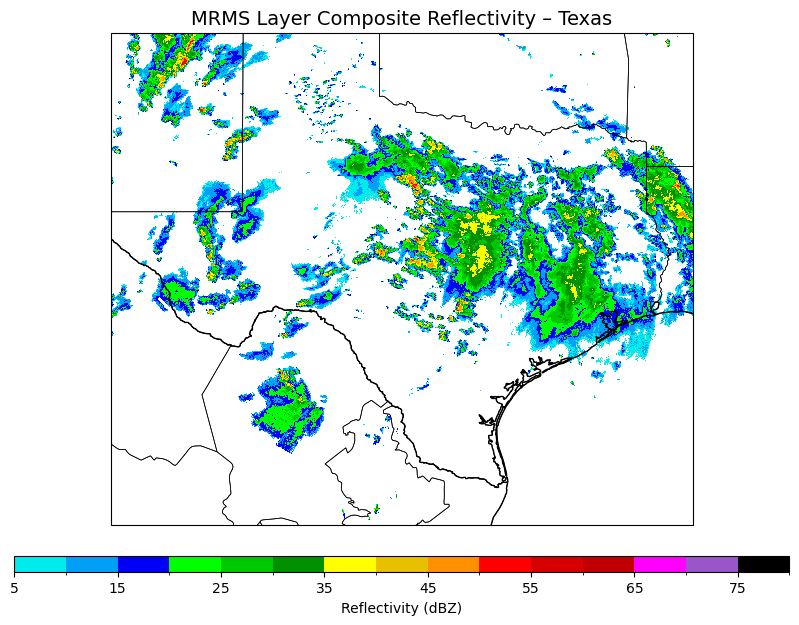

In [4]:
# 3. Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106, -93, 25, 36], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linewidth=0.5)

mesh = ax.pcolormesh(
    lons, lats, ma.masked_where(refl<5,refl),
    cmap=refl_cmap,
    norm=refl_norm,
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('Reflectivity (dBZ)')

plt.title('MRMS Layer Composite Reflectivity – Texas', fontsize=14)
plt.show()


In [5]:
ma.masked_where(refl<5,refl)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=np.float64(1e+20),
  dtype=float32)

### Select Timestamps and Animate Reflectivity

This part of the notebook automates the process of pulling in multiple MRMS reflectivity files and creating an animation to show how low-level reflectivity changed over time.

- **Check for Available Timestamps:**  
  We define a time range from July 4 to July 7, 2025, and loop through it in 30-minute steps. For each time, we generate a file path from the AWS-hosted MRMS archive and try downloading it. If the file exists, we save that timestamp. For this demo, we stop after grabbing six valid files.

- **Set Up the Map and Colormap:**  
  After collecting the timestamps, we build a static map using Cartopy (Plate Carree projection), focused on Texas and surrounding areas. We also apply the MetPy NWSReflectivity colormap and mask out any reflectivity values below 5 dBZ to clean up the visualization.

- **Download and Plot Each Frame:**  
  For each timestamp:
  - The corresponding .grib2.gz file is downloaded and decompressed.
  - We extract the reflectivity data and coordinates using xarray.
  - If the coordinate arrays are 1D, we convert them to 2D for plotting.
  - The reflectivity data is plotted with pcolormesh(), and we add a dynamic title showing the UTC time.
  - Each frame (plot + title) is saved for the animation.

- **Build the Animation:**  
  We use ArtistAnimation from Matplotlib to stitch the frames together into an animation. plt.close(fig) is used beforehand to prevent Jupyter from displaying a static image under the animation.

- **Export as a GIF:**  
  The finished animation is saved as a .gif using Pillow so it can be easily shared or embedded in a presentation.

The result is a short radar loop showing how reflectivity evolved during the early hours of July 4, 2025, which is a period tied to widespread heavy rain and flash flooding across Central Texas.

In [6]:
from datetime import datetime, timedelta


start = datetime(2025, 7, 4, 0, 10, 40)
end = datetime(2025, 7, 7, 0, 0, 0)
step = timedelta(minutes=30)

valid_timestamps = []
t = start

print("Checking for available MRMS files...\n")

while t <= end and len(valid_timestamps) < 6:
    ts = t.strftime("%Y%m%d-%H%M%S")
    date_str = ts[:8]
    url = (
        f"https://noaa-mrms-pds.s3.amazonaws.com/CONUS/LayerCompositeReflectivity_Low_00.50/"
        f"{date_str}/MRMS_LayerCompositeReflectivity_Low_00.50_{ts}.grib2.gz"
    )
    try:
        resp = urllib.request.urlopen(url, timeout=5)
        print(f" Found: {ts}")
        valid_timestamps.append(ts)
    except:
        print(f" Missing: {ts}")
    t += step

print("\n Selected 6 timestamps:")
for ts in valid_timestamps:
    print(ts)


Checking for available MRMS files...

 Found: 20250704-001040
 Missing: 20250704-004040
 Found: 20250704-011040
 Missing: 20250704-014040
 Missing: 20250704-021040
 Missing: 20250704-024040
 Found: 20250704-031040
 Missing: 20250704-034040
 Missing: 20250704-041040
 Missing: 20250704-044040
 Missing: 20250704-051040
 Found: 20250704-054040
 Missing: 20250704-061040
 Missing: 20250704-064040
 Found: 20250704-071040
 Missing: 20250704-074040
 Missing: 20250704-081040
 Missing: 20250704-084040
 Found: 20250704-091040

 Selected 6 timestamps:
20250704-001040
20250704-011040
20250704-031040
20250704-054040
20250704-071040
20250704-091040


In [7]:
# Define the 6 known working timestamps (one every hour)
timestamps = [
    "20250704-001040",
    "20250704-011040",
    "20250704-031040",
    "20250704-054040",
    "20250704-071040",
    "20250704-091040"
]

# Set up colormap and normalization for reflectivity
refl_norm, refl_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

# Initialize animation container
frames_six = []

# Set up static map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106, -93, 25, 36], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Loop through timestamps and collect frames
for ts in timestamps:
    print(f"Loading {ts}...")
    try:
        url = (
            f"https://noaa-mrms-pds.s3.amazonaws.com/CONUS/LayerCompositeReflectivity_Low_00.50/"
            f"{ts[:8]}/MRMS_LayerCompositeReflectivity_Low_00.50_{ts}.grib2.gz"
        )
        response = urllib.request.urlopen(url)
        compressed_file = response.read()

        with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
            f.write(gzip.decompress(compressed_file))
            f.flush()
            data_in = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

        # Extract coordinates and reflectivity data
        lons = data_in.longitude.values
        lats = data_in.latitude.values
        refl = data_in.values

        if lons.ndim == 1 and lats.ndim == 1:
            lons, lats = np.meshgrid(lons, lats)

        # Plot single frame (no show)
        mesh = ax.pcolormesh(
            lons, lats, ma.masked_where(refl < 5, refl),
            cmap=refl_cmap,
            norm=refl_norm,
            transform=ccrs.PlateCarree()
        )

        # Create a title text that updates with each frame
        timestamp_label = f"{ts[:4]}-{ts[4:6]}-{ts[6:8]} {ts[9:11]}:{ts[11:13]} UTC"
        title = ax.text(
            0.5, 1.02,
            f"MRMS Low-Level Reflectivity (dBZ) – {timestamp_label}",
            transform=ax.transAxes,
            ha="center", va="bottom", fontsize=14
        )

        # Save both mesh and title to animation frame
        frames_six.append([mesh, title])

    except Exception as e:
        print(f"Skipped {ts} → {e}")
        continue

# Create and display an animation
plt.close(fig)
anim = ArtistAnimation(fig, frames_six, interval=500, blit=True)
HTML(anim.to_jshtml())

Loading 20250704-001040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-011040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-031040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-054040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-071040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-091040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


In [8]:
from matplotlib.animation import PillowWriter

# Save animation as a .gif
anim.save("mrms_reflectivity_animation.gif", writer=PillowWriter(fps=2))

print("Animation saved as 'mrms_reflectivity_animation.gif'")


Animation saved as 'mrms_reflectivity_animation.gif'


## Reflectivity Animation: Summary

We demonstrated how to access and animate low-level composite reflectivity data from the MRMS system using open-source Python tools. We focused on a short sequence from the July 4, 2025, Central Texas flood event to highlight how reflectivity features evolved.

This workflow is a flexible starting point for working with radar data, especially for case studies or quick visual diagnostics. The next section will continue building on this analysis with more approaches to explore the MRMS dataset!

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Your second content section
Here we can move on to our second objective, and we can demonstrate...

### A subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well as $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**MyST Syntax Overview**](https://mystmd.org/guide/syntax-overview) for MyST-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

You can add [admonitions using MyST syntax](https://mystmd.org/guide/admonitions):

:::{note}
Your relevant information here!
:::

Some other admonitions you can put in ([there are 10 total](https://mystmd.org/guide/admonitions#admonitions-list)):

:::{hint}
A helpful hint.
:::

:::{warning}
Be careful!
:::

:::{danger}
Scary stuff be here.
:::

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!